This notebook aims to show the data processing for the Fruit Ninja model.

1. Lets you upload a gameplay video from `data/raw/`.
2. Uses the shared `extract_patches_from_video` helper to extract candidate patches (potential fruit / bombs / cut fruit).
3. Saves patches into `data/interim/patches/` and metadata into `data/interim/patches_meta.csv`.
4. Provides simple visual previews of random patches.

In [1]:
from pathlib import Path
import sys
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display, HTML

cwd = Path.cwd()

if (cwd / "src").exists():
    PROJECT_ROOT = cwd
elif (cwd.parent / "src").exists():
    PROJECT_ROOT = cwd.parent
else:
    raise RuntimeError(
        f"Could not find 'src' directory from {cwd}. "
        "Adjust PROJECT_ROOT manually."
    )

SRC_DIR = PROJECT_ROOT / "src"
DATA_RAW = PROJECT_ROOT / "data" / "raw"
PATCHES_DIR = PROJECT_ROOT / "data" / "interim" / "patches"
META_PATH = PROJECT_ROOT / "data" / "interim" / "patches_meta.csv"

# Make sure src/ is importable
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

# Import script
from preprocessing.patch_extractor import extract_patches_from_video

# Create dirs if missing
DATA_RAW.mkdir(parents=True, exist_ok=True)
PATCHES_DIR.mkdir(parents=True, exist_ok=True)
META_PATH.parent.mkdir(parents=True, exist_ok=True)

print("Project root:", PROJECT_ROOT)
print("Raw videos:", DATA_RAW)
print("Patches dir:", PATCHES_DIR)
print("Metadata CSV:", META_PATH)


Project root: C:\Users\azure\Documents\Fruit Ninja Bot
Raw videos: C:\Users\azure\Documents\Fruit Ninja Bot\data\raw
Patches dir: C:\Users\azure\Documents\Fruit Ninja Bot\data\interim\patches
Metadata CSV: C:\Users\azure\Documents\Fruit Ninja Bot\data\interim\patches_meta.csv


In [2]:
DATA_RAW = PROJECT_ROOT / "data" / "raw"
videos = sorted(DATA_RAW.glob("*.mp4"))

if not videos:
    raise FileNotFoundError("No .mp4 videos found in data/raw/. Record a session first.")

# Global variable that later cells will use
VIDEO_PATH = None

video_dropdown = widgets.Dropdown(
    options=[str(v) for v in videos],
    description="Choose video:",
    layout=widgets.Layout(width="80%"),
)

select_button = widgets.Button(description="Use this video", button_style="primary")
output = widgets.Output()

def on_select_clicked(b):
    global VIDEO_PATH
    VIDEO_PATH = Path(video_dropdown.value)
    with output:
        output.clear_output()
        print("Selected video:", VIDEO_PATH)

display(HTML("<b>Select a video to process from <code>data/raw</code>:</b>"))
display(video_dropdown, select_button, output)

select_button.on_click(on_select_clicked)

Dropdown(description='Choose video:', layout=Layout(width='80%'), options=('C:\\Users\\azure\\Documents\\Fruit…

Button(button_style='primary', description='Use this video', style=ButtonStyle())

Output()

In [5]:
PATCH_SIZE = 192
FRAME_STRIDE = 4      # process every N-th frame
MIN_AREA = 200        # minimum contour area
MAX_AREA = 20000      # maximum contour area
MAX_FRAMES = None

print("Extraction config:")
print("  PATCH_SIZE  =", PATCH_SIZE)
print("  FRAME_STRIDE =", FRAME_STRIDE)
print("  MIN_AREA    =", MIN_AREA)
print("  MAX_AREA    =", MAX_AREA)
print("  MAX_FRAMES  =", MAX_FRAMES)

Extraction config:
  PATCH_SIZE  = 192
  FRAME_STRIDE = 4
  MIN_AREA    = 200
  MAX_AREA    = 20000
  MAX_FRAMES  = None


In [6]:
video_id = VIDEO_PATH.stem
print("Running extraction on:", VIDEO_PATH)
print("Video ID:", video_id)

# If metadata exists, delete old patches and rows for this video_id
df_existing = None
if META_PATH.exists():
    df_existing = pd.read_csv(META_PATH)
    old_rows = df_existing[df_existing["video_id"] == video_id]

    removed_files = 0
    for _, row in old_rows.iterrows():
        img_path = PATCHES_DIR / row["patch_filename"]
        if img_path.exists():
            img_path.unlink()
            removed_files += 1
    print(f"Deleted {removed_files} old patch images for video_id={video_id}")

    # keep only rows for other videos
    df_existing = df_existing[df_existing["video_id"] != video_id].reset_index(drop=True)
else:
    print("No existing metadata file; starting fresh.")

# Extract new patches for this video
df_new = extract_patches_from_video(
    video_path=VIDEO_PATH,
    output_dir=PATCHES_DIR,
    patch_size=PATCH_SIZE,
    frame_stride=FRAME_STRIDE,
    min_area=400,
    max_area=40000,
    min_aspect=0.7,
    max_aspect=1.4,
    play_top_frac=0.18,
    play_bottom_frac=0.82,
    play_left_frac=0.05,
    play_right_frac=0.95,
    use_motion=True,
    motion_thresh=25,
    max_frames=None,
)

# Save updated metadata
if df_new is not None and not df_new.empty:
    print(f"New patches from this run: {len(df_new)}")

    if df_existing is not None and not df_existing.empty:
        df_combined = pd.concat([df_existing, df_new], ignore_index=True)
    else:
        df_combined = df_new

    df_combined.to_csv(META_PATH, index=False)
    print(
        f"Updated metadata written to {META_PATH}. "
        f"Total patches across all videos: {len(df_combined)}"
    )
else:
    print("No patches extracted for this video. Old patches, if any, were removed.")


Running extraction on: C:\Users\azure\Documents\Fruit Ninja Bot\data\raw\fruitninja2.mp4
Video ID: fruitninja2
Deleted 0 old patch images for video_id=fruitninja2
Processing video: C:\Users\azure\Documents\Fruit Ninja Bot\data\raw\fruitninja2.mp4
Finished C:\Users\azure\Documents\Fruit Ninja Bot\data\raw\fruitninja2.mp4: saved 2102 patches.
New patches from this run: 2102
Updated metadata written to C:\Users\azure\Documents\Fruit Ninja Bot\data\interim\patches_meta.csv. Total patches across all videos: 5909


Total patches in metadata: 5909


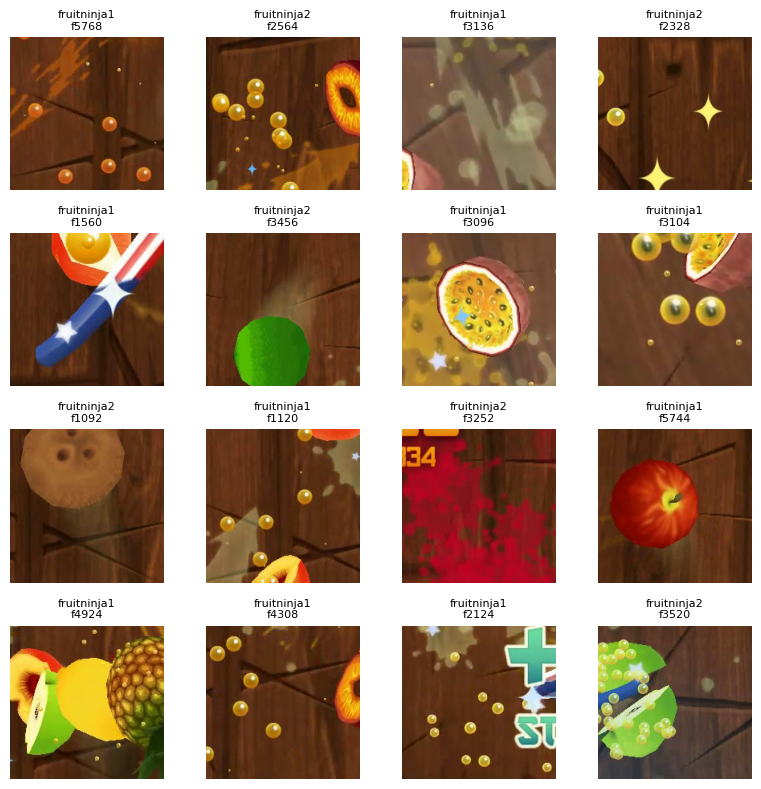

In [7]:
if META_PATH.exists():
    meta_df = pd.read_csv(META_PATH)
    print("Total patches in metadata:", len(meta_df))
else:
    raise FileNotFoundError(f"No metadata found at {META_PATH}")

def show_random_patches(meta_df, patches_dir, n=16, cols=4, figsize=(8, 8)):
    n = min(n, len(meta_df))
    sample_df = meta_df.sample(n=n, random_state=42)

    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.ravel()

    for ax, (_, row) in zip(axes, sample_df.iterrows()):
        img_path = patches_dir / row["patch_filename"]
        img = cv2.imread(str(img_path))
        if img is None:
            ax.axis("off")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        title = f"{row['video_id']}\nf{row['frame_idx']}"
        ax.set_title(title, fontsize=8)
        ax.axis("off")

    for ax in axes[n:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


show_random_patches(meta_df, PATCHES_DIR, n=16, cols=4)

In [8]:
if len(meta_df) == 0:
    print("No patches to browse.")
else:
    idx_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(meta_df) - 1,
        step=1,
        description='Patch index:',
        continuous_update=False,
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='80%')
    )

    out = widgets.Output()

    def on_value_change(change):
        idx = change['new']
        row = meta_df.iloc[idx]
        img_path = PATCHES_DIR / row["patch_filename"]
        img = cv2.imread(str(img_path))
        if img is None:
            return
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        with out:
            out.clear_output(wait=True)
            plt.figure(figsize=(3, 3))
            plt.imshow(img)
            plt.axis("off")
            plt.title(
                f"{row['patch_filename']}\n"
                f"video={row['video_id']}, frame={row['frame_idx']}",
                fontsize=9
            )
            plt.show()

    idx_slider.observe(on_value_change, names='value')
    display(idx_slider, out)
    on_value_change({'new': 0})

IntSlider(value=0, continuous_update=False, description='Patch index:', layout=Layout(width='80%'), max=5908, …

Output()

Afterwards, manually go through the patches and move them to the correct `data/processed` folder. We will then create a .csv based on the files in the processed folder.

In [9]:
PROCESSED_PATCHES = PROJECT_ROOT / "data" / "processed" / "patches"
OUT_CSV = PROCESSED_PATCHES / "patches_labeled.csv"

# Load full metadata from extraction stage
meta_df = pd.read_csv(META_PATH)
meta_df.set_index("patch_filename", inplace=True)

# Load and clean existing processed CSV if it exists

existing_df = None
if OUT_CSV.exists():
    print(f"Found existing labeled CSV at: {OUT_CSV}")
    existing_df = pd.read_csv(OUT_CSV)
    if "label" not in existing_df.columns:
        print("WARNING: existing CSV has no 'label' column; ignoring it.")
        existing_df = None
    else:
        print("Rows in existing CSV BEFORE cleaning:", len(existing_df))

        def file_exists(row):
            img_path = PROCESSED_PATCHES / row["label"] / row["patch_filename"]
            return img_path.exists()

        mask = existing_df.apply(file_exists, axis=1)
        cleaned_existing = existing_df[mask].reset_index(drop=True)
        removed = len(existing_df) - len(cleaned_existing)
        print(f"Removed {removed} rows with missing files.")
        existing_df = cleaned_existing
        print("Rows in existing CSV AFTER cleaning:", len(existing_df))
else:
    print("No existing labeled CSV; starting fresh.")

# Scan current folder structure and build new rows
rows = []

for label_dir in PROCESSED_PATCHES.iterdir():
    if not label_dir.is_dir():
        continue
    label = label_dir.name  # e.g. 'fruit', 'cut_fruit', 'bomb'

    for img_path in label_dir.glob("*.png"):
        fname = img_path.name

        row = {
            "patch_filename": fname,
            "label": label,
        }

        # Attach metadata if we have it
        if fname in meta_df.index:
            m = meta_df.loc[fname]
            row.update(
                {
                    "video_id": m.get("video_id", None),
                    "frame_idx": m.get("frame_idx", None),
                    "center_x_norm": m.get("center_x_norm", None),
                    "center_y_norm": m.get("center_y_norm", None),
                    "bbox_x": m.get("bbox_x", None),
                    "bbox_y": m.get("bbox_y", None),
                    "bbox_w": m.get("bbox_w", None),
                    "bbox_h": m.get("bbox_h", None),
                }
            )

        rows.append(row)

new_df = pd.DataFrame(rows)
print("New rows from current folders:", len(new_df))

# Merge cleaned existing with new rows
if existing_df is not None and not existing_df.empty:
    # Treat patch_filename as key: new rows override old for same filename
    # Drop any existing rows whose patch_filename appears in new_df
    existing_df = existing_df[
        ~existing_df["patch_filename"].isin(new_df["patch_filename"])
    ].reset_index(drop=True)

    combined_df = pd.concat([existing_df, new_df], ignore_index=True)
else:
    combined_df = new_df

combined_df.to_csv(OUT_CSV, index=False)
print("Saved labeled CSV to:", OUT_CSV)
print("Total rows in labeled CSV:", len(combined_df))
print(combined_df["label"].value_counts())

No existing labeled CSV; starting fresh.
New rows from current folders: 946
Saved labeled CSV to: C:\Users\azure\Documents\Fruit Ninja Bot\data\processed\patches\patches_labeled.csv
Total rows in labeled CSV: 946
label
cut_fruit    438
fruit        291
bomb         217
Name: count, dtype: int64
